<a href="https://colab.research.google.com/github/batmanscode/breast-cancer-wisconsin/blob/master/breast_cancer_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast cancer diagnosis using the wisconsin dataset from kaggle

## This notebook contains a bit of EDA and the steps used to create the pkl file that the app uses



In [ ]:
# use if you want to use with Google Drive

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
pip install tpot

In [ ]:
pip install heatmapz

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier
from heatmap import heatmap, corrplot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## import data

In [ ]:
full_data = pd.read_csv("data.csv")

# or use
# full_data = pd.read_csv("https://raw.githubusercontent.com/batmanscode/breast-cancer-wisconsin/master/data.csv")
# to read directly from github

full_data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


## clean data

In [ ]:
# id is unnecessary and unnamed: 32 is empty so going to remove them
data = full_data.drop(['id', 'Unnamed: 32'], axis=1)

# could also remove a column full of empty values with:
# data.dropna(axis=1, how='all', inplace=True)

# convert M, B to 1,0
data['diagnosis'] = data['diagnosis'].map({'M':1,'B':0})

data

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


### let's visualize with a heatmap

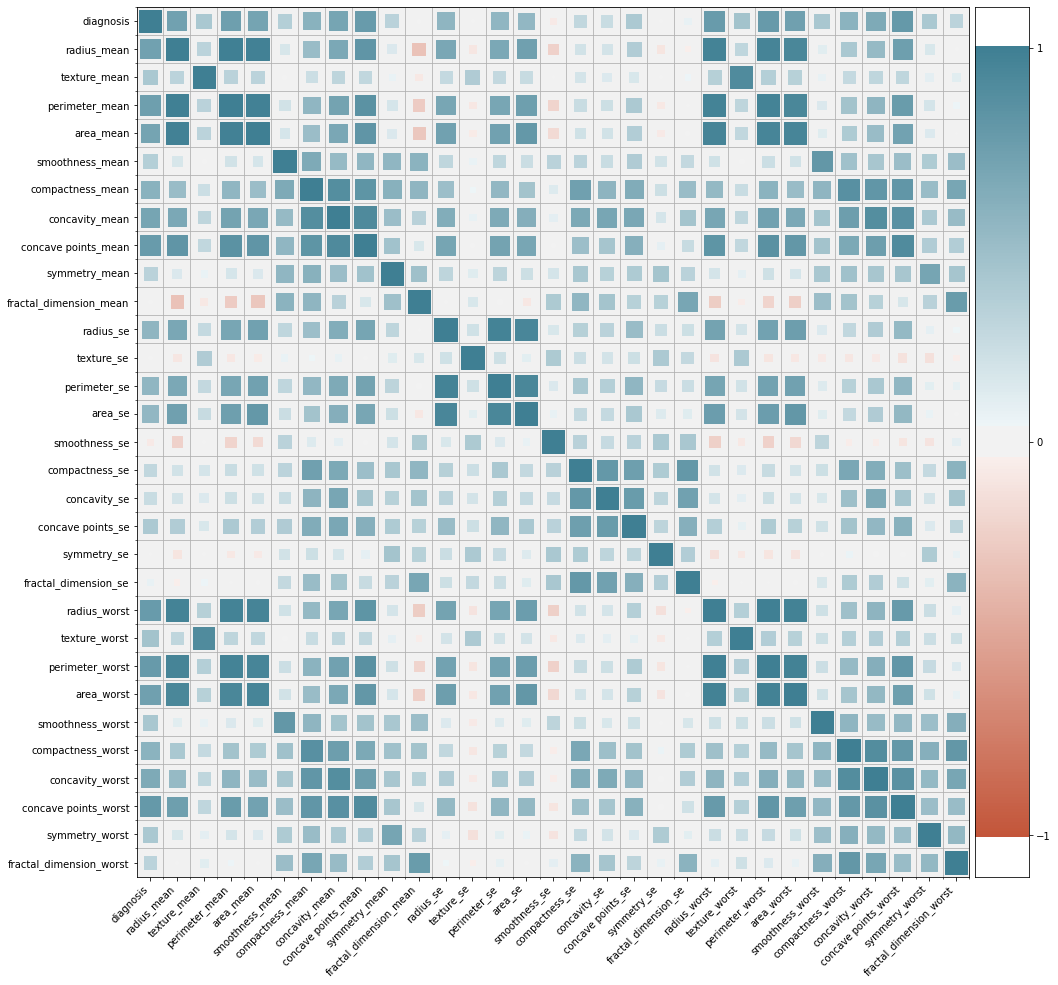

In [ ]:
plt.figure(figsize=(16, 16))
corrplot(data.corr(), size_scale=500);

## now lets look at the correlations of features vs diagnosis

In [ ]:
corr_features = data.drop('diagnosis', axis=1).apply(lambda x: x.corr(data['diagnosis']))
corr_features

radius_mean                0.730029
texture_mean               0.415185
perimeter_mean             0.742636
area_mean                  0.708984
smoothness_mean            0.358560
compactness_mean           0.596534
concavity_mean             0.696360
concave points_mean        0.776614
symmetry_mean              0.330499
fractal_dimension_mean    -0.012838
radius_se                  0.567134
texture_se                -0.008303
perimeter_se               0.556141
area_se                    0.548236
smoothness_se             -0.067016
compactness_se             0.292999
concavity_se               0.253730
concave points_se          0.408042
symmetry_se               -0.006522
fractal_dimension_se       0.077972
radius_worst               0.776454
texture_worst              0.456903
perimeter_worst            0.782914
area_worst                 0.733825
smoothness_worst           0.421465
compactness_worst          0.590998
concavity_worst            0.659610
concave points_worst       0

there are no strong negative correlations so we can filter only with the most positively correlated

let's have a look at the top 8

---

ref:

[sort by value](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.sort_values.html)

[then sort by top n values](https://stackoverflow.com/questions/16958499/sort-pandas-dataframe-and-print-highest-n-values#36709634)  

[slider](https://colab.research.google.com/notebooks/forms.ipynb#scrollTo=eFN7-fUKs-Bu)




In [ ]:
#@title top n features { run: "auto" }
sort_by = 8 #@param {type:"slider", min:1, max:30, step:1}

corr_features.sort_values(ascending=False).head(sort_by)

concave points_worst    0.793566
perimeter_worst         0.782914
concave points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
area_worst              0.733825
radius_mean             0.730029
area_mean               0.708984
dtype: float64

### keep only highly correlated features

alright now we can remove any features that have a very similar correlation


*example:*

>concave points_mean     0.776614

and

>radius_worst            0.776454

are very similar so we can remove one of them since either one will have a nearly identical effect on our prediction  

radius seems the easier to of the two to measure so let's keep that and **drop concave points**

other similar features:

>area_worst              0.733825  
>radius_mean             0.730029  

let's **drop area_worst**

In [ ]:
top_corr_features = corr_features.sort_values(ascending=False).head(8)

top_corr_features

concave points_worst    0.793566
perimeter_worst         0.782914
concave points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
area_worst              0.733825
radius_mean             0.730029
area_mean               0.708984
dtype: float64

In [ ]:
top_corr_features.drop(['concave points_mean', 'area_worst'], inplace=True)

In [ ]:
top_corr_features

concave points_worst    0.793566
perimeter_worst         0.782914
radius_worst            0.776454
perimeter_mean          0.742636
radius_mean             0.730029
area_mean               0.708984
dtype: float64

In [ ]:
print(f"great, now we have our top {len(top_corr_features)}!")

great, now we have our top 6!


### create and export the new, cleaned dataframe :D

In [ ]:
# new cleaned dataframe

cleaned_data = data.filter(['diagnosis',
                            'concave points_worst',
                            'perimeter_worst',
                            'radius_worst',
                            'perimeter_mean',
                            'radius_mean',
                            'area_mean'])

cleaned_data

,diagnosis,concave points_worst,perimeter_worst,radius_worst,perimeter_mean,radius_mean,area_mean
0,1,0.2654,184.60,25.380,122.80,17.99,1001.0
1,1,0.1860,158.80,24.990,132.90,20.57,1326.0
2,1,0.2430,152.50,23.570,130.00,19.69,1203.0
3,1,0.2575,98.87,14.910,77.58,11.42,386.1
4,1,0.1625,152.20,22.540,135.10,20.29,1297.0
...,...,...,...,...,...,...,...
564,1,0.2216,166.10,25.450,142.00,21.56,1479.0
565,1,0.1628,155.00,23.690,131.20,20.13,1261.0
566,1,0.1418,126.70,18.980,108.30,16.60,858.1
567,1,0.2650,184.60,25.740,140.10,20.60,1265.0


In [ ]:
# if you want to save to drive
# cleaned_data.to_csv("drive/My Drive/cleaned_data.csv", index=False)

cleaned_data.to_csv("cleaned_data.csv", index=False)

In [ ]:
# check df
check_cleaned_data = pd.read_csv('cleaned_data.csv')
check_cleaned_data

,diagnosis,concave points_worst,perimeter_worst,radius_worst,perimeter_mean,radius_mean,area_mean
0,1,0.2654,184.60,25.380,122.80,17.99,1001.0
1,1,0.1860,158.80,24.990,132.90,20.57,1326.0
2,1,0.2430,152.50,23.570,130.00,19.69,1203.0
3,1,0.2575,98.87,14.910,77.58,11.42,386.1
4,1,0.1625,152.20,22.540,135.10,20.29,1297.0
...,...,...,...,...,...,...,...
564,1,0.2216,166.10,25.450,142.00,21.56,1479.0
565,1,0.1628,155.00,23.690,131.20,20.13,1261.0
566,1,0.1418,126.70,18.980,108.30,16.60,858.1
567,1,0.2650,184.60,25.740,140.10,20.60,1265.0


## time to train!

In [ ]:
# but first let's split our cleaned data
# let's also use random_state=42 (or anything else) for everything so the results will be the same each time we run this notebook

X = cleaned_data.drop('diagnosis', axis=1)
y= cleaned_data["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=42)

### fit and score on tpot

In [ ]:
tpot = TPOTClassifier(verbosity=2, early_stop=30, random_state=42)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))


Generation 1 - Current best internal CV score: 0.9516483516483518
Generation 2 - Current best internal CV score: 0.9516483516483518
Generation 3 - Current best internal CV score: 0.953846153846154
Generation 4 - Current best internal CV score: 0.953846153846154
Generation 5 - Current best internal CV score: 0.9582417582417584
Generation 6 - Current best internal CV score: 0.9582417582417584
Generation 7 - Current best internal CV score: 0.9604395604395606
Generation 8 - Current best internal CV score: 0.9604395604395606
Generation 9 - Current best internal CV score: 0.9604395604395606
Generation 10 - Current best internal CV score: 0.9604395604395606
Generation 11 - Current best internal CV score: 0.9604395604395606
Generation 12 - Current best internal CV score: 0.9604395604395606
Generation 13 - Current best internal CV score: 0.9604395604395606
Generation 14 - Current best internal CV score: 0.9604395604395606
Generation 15 - Current best internal CV score: 0.9604395604395606
Gener

### export and then run the exported pipeline

In [ ]:
# to save to drive use this
# tpot.export("drive/My Drive/cleaned_data_pipeline.py")


In [ ]:
tpot.export('cleaned_data_pipeline.py')

## exported pipeline

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('cleaned_data.csv')
features = tpot_data.drop('diagnosis', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['diagnosis'], random_state=42, test_size=0.2)

# Average CV score on the training set was: 0.9670329670329672
exported_pipeline = make_pipeline(
    StandardScaler(),
    RBFSampler(gamma=0.8500000000000001),
    ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.55, min_samples_leaf=10, min_samples_split=15, n_estimators=100)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


## evaluate the model

In [ ]:
results

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1])

In [ ]:
predicted_probabilities = exported_pipeline.predict_proba(testing_features)
predicted_probabilities

array([[8.84220134e-01, 1.15779866e-01],
       [6.72727273e-03, 9.93272727e-01],
       [1.67703349e-02, 9.83229665e-01],
       [9.93983974e-01, 6.01602564e-03],
       [9.95455586e-01, 4.54441392e-03],
       [5.95252576e-02, 9.40474742e-01],
       [5.48449862e-02, 9.45155014e-01],
       [5.56852332e-02, 9.44314767e-01],
       [1.27481157e-01, 8.72518843e-01],
       [9.72933198e-01, 2.70668025e-02],
       [1.00000000e+00, 0.00000000e+00],
       [2.58681874e-02, 9.74131813e-01],
       [8.02246726e-01, 1.97753274e-01],
       [5.98221203e-01, 4.01778797e-01],
       [9.72013793e-01, 2.79862068e-02],
       [8.18284375e-02, 9.18171563e-01],
       [8.99240223e-01, 1.00759777e-01],
       [9.89944444e-01, 1.00555556e-02],
       [7.51742918e-01, 2.48257082e-01],
       [3.40909091e-03, 9.96590909e-01],
       [3.68640277e-01, 6.31359723e-01],
       [9.90867041e-01, 9.13295915e-03],
       [2.93405973e-02, 9.70659403e-01],
       [9.93183081e-01, 6.81691919e-03],
       [9.990000

In [ ]:
for B, M in predicted_probabilities:
  print(f"{B*100:.2f}% chance of being benign | {M*100:.2f}% chance of being malignant")

88.42% chance of being benign | 11.58% chance of being malignant
0.67% chance of being benign | 99.33% chance of being malignant
1.68% chance of being benign | 98.32% chance of being malignant
99.40% chance of being benign | 0.60% chance of being malignant
99.55% chance of being benign | 0.45% chance of being malignant
5.95% chance of being benign | 94.05% chance of being malignant
5.48% chance of being benign | 94.52% chance of being malignant
5.57% chance of being benign | 94.43% chance of being malignant
12.75% chance of being benign | 87.25% chance of being malignant
97.29% chance of being benign | 2.71% chance of being malignant
100.00% chance of being benign | 0.00% chance of being malignant
2.59% chance of being benign | 97.41% chance of being malignant
80.22% chance of being benign | 19.78% chance of being malignant
59.82% chance of being benign | 40.18% chance of being malignant
97.20% chance of being benign | 2.80% chance of being malignant
8.18% chance of being benign | 91.8

In [ ]:
len(testing_target)

114

In [ ]:
len(y_test)

114

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(testing_target, results, normalize=True)

0.9649122807017544

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(testing_target, results)

array([[69,  2],
       [ 2, 41]])

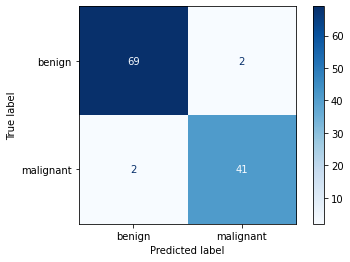

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(exported_pipeline, testing_features, testing_target, display_labels=['benign', 'malignant'], cmap='Blues')

# testing_features = X_test
# testing_target = y_test

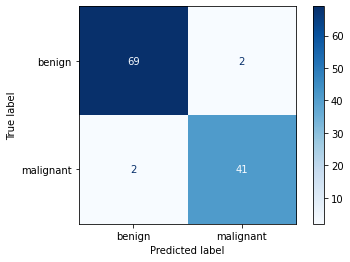

In [ ]:
# as you can see they produce the same confusion matrix

from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(exported_pipeline, X_test, y_test, display_labels=['benign', 'malignant'], cmap='Blues')

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(testing_target, results))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        71
           1       0.95      0.95      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



In [ ]:
#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(testing_target, results).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  69
False Positives:  2
False Negatives:  2
True Positives:  41


In [ ]:
#Accuracy
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print(f"Accuracy {Accuracy}")

Accuracy 96.49122807017544


In [ ]:
tnr = tn/(tn+fn)*100
fpr = fp/(tp+fp)*100
fnr = fn/(tn+fn)*100
tpr = tp/(fp+tp)*100

print(f"True negative rate: {tnr:.2f}%")
print(f"False Positive rate: {fpr:.2f}%")
print(f"False Negative rate: {fnr:.2f}%")
print(f"True Positive rate: {tpr:.2f}%")
print(f"General accuracy score: {Accuracy:.2f}")


True negative rate: 97.18%
False Positive rate: 4.65%
False Negative rate: 2.82%
True Positive rate: 95.35%
General accuracy score: 96.49


## pickle the model

### save pkl

In [ ]:
import pickle

# to save to drive
# pickle.dump(exported_pipeline, open("/content/drive/My Drive/pkl_of_exported_pipeline.pkl", "wb"))

pickle.dump(exported_pipeline, open("pkl_of_exported_pipeline.pkl", "wb"))

### load pkl

In [ ]:
loaded_pkl = pickle.load(open("pkl_of_exported_pipeline.pkl", "rb"))

and now let's run the same evaluation functions as the exported_pipeline model

In [ ]:
pkl_results = loaded_pkl.predict(testing_features)
pkl_results

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1])

In [ ]:
len(pkl_results)

114

In [ ]:
results

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1])

In [ ]:
len(results)

114

In [ ]:
#checking if 'pkl_results' are the same as 'results' (from the model before exporting)

# if results == pkl_results:
#   print("the models exported right!")

np.array_equal(results, pkl_results)

True

## Alright! We're done! 💯 You can now use this pkl file to make predictions

